In [10]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers import Input, Activation, LeakyReLU, Dropout
from keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [12]:
import warnings
warnings.filterwarnings('ignore')

MAIN_DIR = 'C:/Users/om/OneDrive/Desktop/codeclause project 2/brain_tumor_dataset'
SEED = 40
os.listdir(MAIN_DIR)

['no', 'yes']

In [13]:
subdirs = os.listdir(MAIN_DIR)[:2]
for subdir in subdirs:
    print(f"{subdir} contains {len(os.listdir(MAIN_DIR+'/'+subdir))} images")

no contains 98 images
yes contains 155 images


In [14]:
def load_images(folder):
    
    imgs = []
    target = 0
    labels = []
    for i in os.listdir(folder):
        subdir = os.path.join(folder, i)
        for j in os.listdir(subdir):
            img_dir = os.path.join(subdir,j)
            try:
                img = cv2.imread(img_dir)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (128,128))
                imgs.append(img)
                labels.append(target)
            except:
                continue
        target += 1
    
    imgs = np.array(imgs)
    labels = np.array(labels)
    
    return imgs, labels

In [15]:
data, labels = load_images(MAIN_DIR)
data.shape, labels.shape

((253, 128, 128), (253,))

In [16]:
def plot_images(start, end):
    plt.figure(figsize=(22,8))
    for i in range(10):
        axs = plt.subplot(2,5, i+1)
        idx = np.random.randint(start, end)
        plt.imshow(data[idx], cmap='gray')
        plt.axis('on')
        axs.set_xticklabels([])
        axs.set_yticklabels([])
        plt.subplots_adjust(wspace=None, hspace=None)

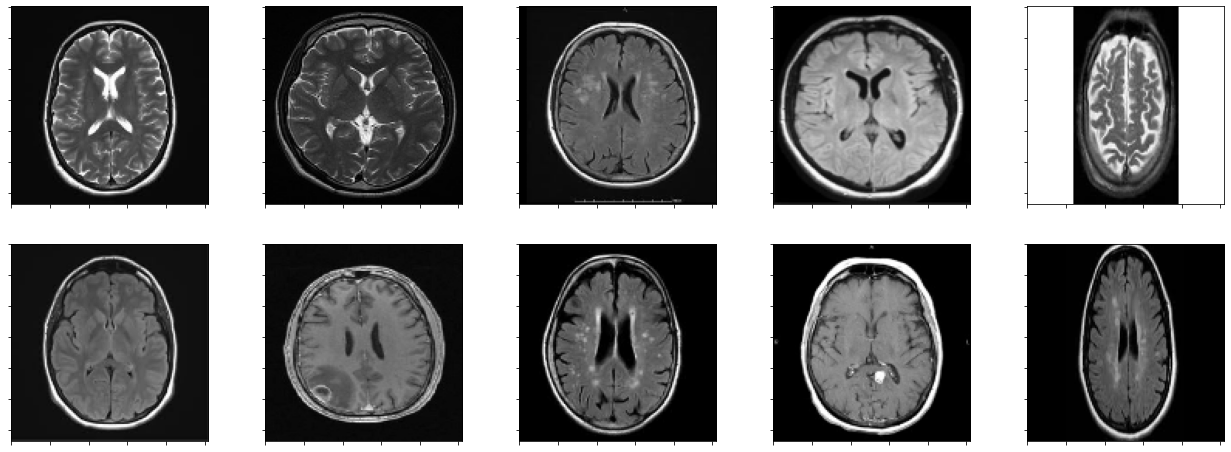

In [17]:
plot_images(0, 97) # 0 to 97 for images with no tumor

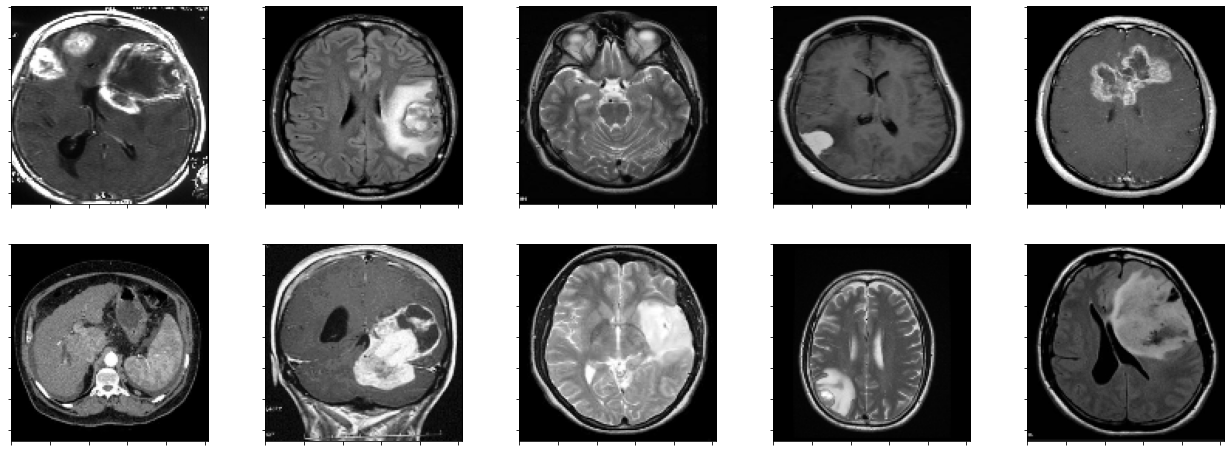

In [10]:
plot_images(98, 252) # 98 to 252 for images with tumor

In [11]:
#NORMALISING DATA

In [18]:
norm_data = data / 255. 
norm_data = np.expand_dims(norm_data, axis=3)
norm_data.shape, norm_data[0]

((253, 128, 128, 1),
 array([[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        ...,
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]]))

In [19]:
tf.random.set_seed(SEED) #APPLYING CNN

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64,
                           kernel_size=3,
                           activation='relu',
                           input_shape=(128,128,1)),
    tf.keras.layers.Conv2D(32,3,activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2,
                              padding='valid'),
    tf.keras.layers.Conv2D(32,3,activation='relu'),
    tf.keras.layers.Conv2D(16,3,activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history = model.fit(norm_data, labels, epochs=10, validation_split=0.20)

Epoch 1/10
7/7 [==============================] - 8s 1s/step - loss: 0.6368 - accuracy: 0.6485 - val_loss: 0.2454 - val_accuracy: 0.9608
Epoch 2/10
7/7 [==============================] - 7s 975ms/step - loss: 0.5920 - accuracy: 0.6782 - val_loss: 0.3748 - val_accuracy: 0.8824
Epoch 3/10
7/7 [==============================] - 7s 948ms/step - loss: 0.5304 - accuracy: 0.7723 - val_loss: 0.5449 - val_accuracy: 0.7059
Epoch 4/10
7/7 [==============================] - 7s 979ms/step - loss: 0.4942 - accuracy: 0.7475 - val_loss: 0.4396 - val_accuracy: 0.8235
Epoch 5/10
7/7 [==============================] - 6s 909ms/step - loss: 0.4765 - accuracy: 0.7723 - val_loss: 0.4921 - val_accuracy: 0.7843
Epoch 6/10
7/7 [==============================] - 7s 950ms/step - loss: 0.4457 - accuracy: 0.7921 - val_loss: 0.5379 - val_accuracy: 0.7451
Epoch 7/10
7/7 [==============================] - 7s 943ms/step - loss: 0.3913 - accuracy: 0.8119 - val_loss: 0.4699 - val_accuracy: 0.7647
Epoch 8/10
7/7 [=======

In [21]:
#EVALUATION
result = model.evaluate(norm_data, labels, verbose=0)
print(f"Accuracy on Evaluation: {result[1]*100:.2f}%\nLoss: {result[0]:.4f}")

Accuracy on Evaluation: 92.09%
Loss: 0.2307


In [15]:
#The Evalutaion is done on the training data itself, which may not present how well the model will do on unseen data
#So now we will make predictions on randomly picked images from the training data and compare the results

In [22]:
# Generating 20 random numbers to index from data

np.random.seed(SEED)
idxs = np.random.randint(0, 252, 20)

In [23]:
y_pred_prob = model.predict(norm_data[idxs])
y_pred = np.array([1 if prob>0.5 else 0 for prob in y_pred_prob])

y_true = labels[idxs]
y_pred.shape, y_true.shape

1/1 [==============================] - 0s 160ms/step


((20,), (20,))

In [24]:
y_pred

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1])

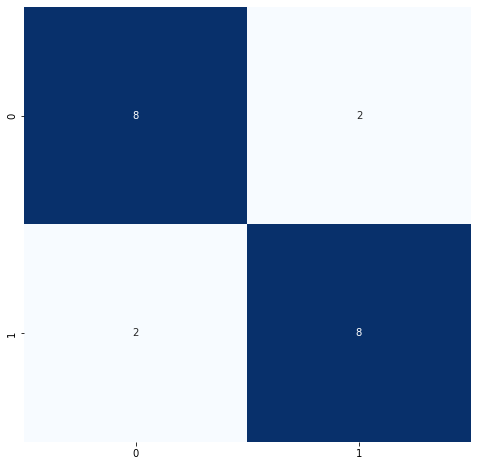

In [25]:
plt.figure(figsize=(8,8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, cmap="Blues", annot=True, fmt=".2g", cbar=False)
plt.show()

In [26]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.80      0.80      0.80        10

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20



In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 32)      18464     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 58, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 16)       0         
 2D)                                                    

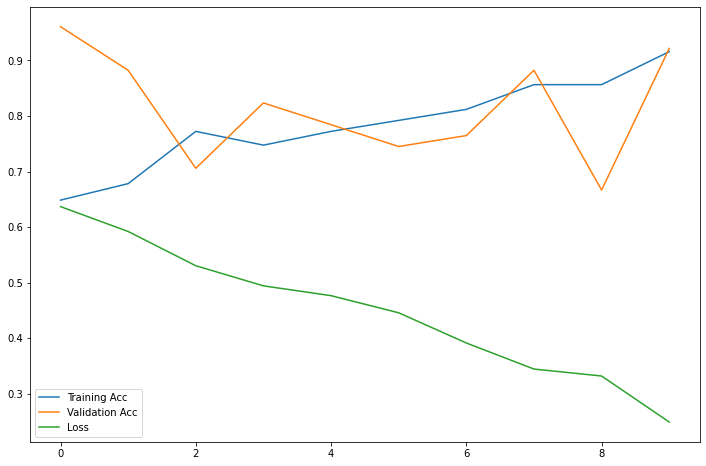

In [28]:
histdf = pd.DataFrame(history.history)

plt.figure(figsize=(12,8))
plt.plot(histdf['accuracy'], label='Training Acc')
plt.plot(histdf['val_accuracy'], label='Validation Acc')
plt.plot(histdf['loss'], label='Loss')
plt.legend()
plt.show()